## Importing necessary libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import classification_report, make_scorer
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor


## Importing dataset

In [4]:
df = pd.read_excel('premiums_young_with_gr.xlsx')

In [5]:
#First few rows of dataset
df.head(5)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount,Genetical_Risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,1


## Data Cleaning

In [6]:
#Checking for any null rows
print('Size of the dataframe: ', df.shape)
df.isna().sum()


Size of the dataframe:  (20096, 14)


Age                      0
Gender                   0
Region                   0
Marital_status           0
Number Of Dependants     0
BMI_Category             0
Smoking_Status           2
Employment_Status        1
Income_Level             4
Income_Lakhs             0
Medical History          0
Insurance_Plan           0
Annual_Premium_Amount    0
Genetical_Risk           0
dtype: int64

In [7]:
# Removing rows with missing values (only a few), as imputing them isn't necessary and may introduce noise
df.dropna(inplace=True)
print('Size of the new dataframe: ', df.shape)

Size of the new dataframe:  (20090, 14)


In [8]:
#Converting any dependents to a positive number
df['Number Of Dependants'] = abs(df['Number Of Dependants'])

In [9]:
df.describe()

,Age,Number Of Dependants,Income_Lakhs,Annual_Premium_Amount,Genetical_Risk
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267,2.503932
std,2.294052,0.937200,23.420493,2749.906347,1.710203
min,18.000000,0.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.250000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,790.000000,18186.000000,5.000000


In [10]:
#Checking how many rows have age greater than 100
df[df['Age']>100].shape

#Dropping rows where age is greater than 100
df = df[df['Age'] <= 100]

In [11]:
df.describe()

,Age,Number Of Dependants,Income_Lakhs,Annual_Premium_Amount,Genetical_Risk
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267,2.503932
std,2.294052,0.937200,23.420493,2749.906347,1.710203
min,18.000000,0.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.250000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,790.000000,18186.000000,5.000000


In [12]:
#Dropping valyes where Income is unreasonable
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

lower, upper = get_iqr_bounds(df['Income_Lakhs'])
lower, upper

quantile_thresold = df['Income_Lakhs'].quantile(0.999)
quantile_thresold

df1 = df[df['Income_Lakhs'] <= quantile_thresold].copy()
df1.shape

(20086, 14)

In [13]:
print("Shape of new dataframe:", df1.shape)
df1.describe()

Shape of new dataframe: (20086, 14)


,Age,Number Of Dependants,Income_Lakhs,Annual_Premium_Amount,Genetical_Risk
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,21.494474,0.722742,22.390371,8141.799263,2.503883
std,2.294248,0.937238,21.732062,2749.912486,1.710184
min,18.000000,0.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.000000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,100.000000,18186.000000,5.000000


In [14]:
print(df1.columns.tolist())

['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants', 'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level', 'Income_Lakhs', 'Medical History', 'Insurance_Plan', 'Annual_Premium_Amount', 'Genetical_Risk']


In [15]:
categorical_cols = ['Gender', 'Region', 'Marital_status', 'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level', 'Medical History', 'Insurance_Plan']
for col in categorical_cols:
    print(col, ":", df1[col].unique())

Gender : ['Male' 'Female']
Region : ['Northeast' 'Northwest' 'Southeast' 'Southwest']
Marital_status : ['Unmarried' 'Married']
BMI_Category : ['Overweight' 'Underweight' 'Normal' 'Obesity']
Smoking_Status : ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
Employment_Status : ['Self-Employed' 'Freelancer' 'Salaried']
Income_Level : ['> 40L' '<10L' '10L - 25L' '25L - 40L']
Medical History : ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
Insurance_Plan : ['Silver' 'Bronze' 'Gold']


In [16]:
df1['Smoking_Status'] = df1['Smoking_Status'].map({
    'Not Smoking': 'No Smoking',
    'Does Not Smoke': 'No Smoking',
    'Smoking=0': 'No Smoking'
}).fillna(df1['Smoking_Status'])


df1['Smoking_Status'].unique()

array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

## Feature Engineering for Diabetes column 

In [17]:
# Split 'Medical History' into two columns
df1[['disease1', 'disease2']] = (
    df1['Medical History'].str.split(" & ", expand=True)
    .apply(lambda x: x.str.lower())
)

# Avoid inplace and chained assignment warnings
df1['disease1'] = df1['disease1'].fillna('none')
df1['disease2'] = df1['disease2'].fillna('none')

# Define risk scores
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure": 6,
    "thyroid": 5,
    "no disease": 0,
    "none": 0
}

# Calculate total risk score
df1['total_risk_score'] = 0
for disease in ['disease1', 'disease2']:
    df1['total_risk_score'] += df1[disease].map(risk_scores)

# Normalize to [0, 1]
max_score = df1['total_risk_score'].max()
min_score = df1['total_risk_score'].min()
df1['normalized_risk_score'] = (df1['total_risk_score'] - min_score) / (max_score - min_score)

df1.sample(5)


,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount,Genetical_Risk,disease1,disease2,total_risk_score,normalized_risk_score
7837,22,Male,Southeast,Unmarried,0,Normal,No Smoking,Self-Employed,> 40L,71,No Disease,Silver,10212,3,no disease,none,0,0.0
11851,25,Female,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,<10L,1,No Disease,Bronze,8485,4,no disease,none,0,0.0
1170,24,Male,Southwest,Unmarried,1,Normal,Occasional,Freelancer,<10L,1,No Disease,Gold,14316,3,no disease,none,0,0.0
18453,21,Male,Northwest,Married,3,Normal,No Smoking,Salaried,<10L,5,No Disease,Bronze,3801,0,no disease,none,0,0.0
5872,22,Male,Southwest,Unmarried,1,Overweight,No Smoking,Freelancer,25L - 40L,32,No Disease,Bronze,9093,5,no disease,none,0,0.0


In [18]:
df1['Insurance_Plan'] = df1['Insurance_Plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})
df1['Income_Level'] = df1['Income_Level'].map({'<10L':1, '10L - 25L': 2, '25L - 40L':3, '> 40L':4})

In [19]:
df1.sample(5)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount,Genetical_Risk,disease1,disease2,total_risk_score,normalized_risk_score
981,18,Male,Southeast,Unmarried,1,Normal,No Smoking,Salaried,2,13,No Disease,2,12472,5,no disease,none,0,0.0
6374,22,Male,Southeast,Unmarried,0,Overweight,Regular,Freelancer,1,3,No Disease,1,5988,1,no disease,none,0,0.0
3858,24,Male,Northeast,Married,3,Overweight,No Smoking,Self-Employed,1,5,No Disease,1,9756,5,no disease,none,0,0.0
16705,20,Male,Southwest,Unmarried,0,Underweight,No Smoking,Salaried,4,91,No Disease,2,12073,4,no disease,none,0,0.0
10776,22,Male,Southwest,Unmarried,0,Normal,Regular,Freelancer,3,27,No Disease,1,5802,1,no disease,none,0,0.0


In [20]:
#Avoid multi-collinearity 

nominal_cols = ['Gender', 'Region', 'Marital_status', 'BMI_Category', 'Smoking_Status', 'Employment_Status']
df2 = pd.get_dummies(df1, columns=nominal_cols, drop_first=True, dtype=int)
df2.sample(5)

,Age,Number Of Dependants,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount,Genetical_Risk,disease1,disease2,...,Region_Southeast,Region_Southwest,Marital_status_Unmarried,BMI_Category_Obesity,BMI_Category_Overweight,BMI_Category_Underweight,Smoking_Status_Occasional,Smoking_Status_Regular,Employment_Status_Salaried,Employment_Status_Self-Employed
16904,25,0,1,9,No Disease,1,4546,0,no disease,none,...,1,0,1,0,1,0,0,1,1,0
4433,22,1,1,3,High blood pressure & Heart disease,1,8101,3,high blood pressure,heart disease,...,0,1,1,0,0,0,0,0,0,0
13967,19,3,1,4,No Disease,1,3806,0,no disease,none,...,0,1,0,0,0,1,0,0,0,0
13173,18,1,1,7,No Disease,1,9617,5,no disease,none,...,0,0,1,0,0,0,1,0,0,0
9759,18,0,1,7,No Disease,3,12764,1,no disease,none,...,1,0,1,0,1,0,1,0,1,0


In [21]:
df3 = df2.drop(['Medical History','disease1', 'disease2', 'total_risk_score'], axis=1)
df3.sample(5)                

,Age,Number Of Dependants,Income_Level,Income_Lakhs,Insurance_Plan,Annual_Premium_Amount,Genetical_Risk,normalized_risk_score,Gender_Male,Region_Northwest,Region_Southeast,Region_Southwest,Marital_status_Unmarried,BMI_Category_Obesity,BMI_Category_Overweight,BMI_Category_Underweight,Smoking_Status_Occasional,Smoking_Status_Regular,Employment_Status_Salaried,Employment_Status_Self-Employed
1568,24,0,1,3,1,6725,3,0.000000,0,1,0,0,1,0,0,0,0,0,0,1
17522,21,2,2,16,1,7666,4,0.000000,1,0,1,0,1,0,0,1,0,0,0,1
19567,20,1,2,12,2,12729,4,0.428571,1,0,1,0,1,0,0,0,0,1,1,0
11968,24,1,1,5,2,12273,5,0.000000,0,1,0,0,1,0,0,0,0,0,1,0
11023,25,0,2,14,1,8490,4,0.000000,0,1,0,0,1,0,1,0,0,0,0,0


## Scaling (to have features in same range)

In [22]:
X = df3.drop('Annual_Premium_Amount', axis='columns')
y = df3['Annual_Premium_Amount']

from sklearn.preprocessing import MinMaxScaler

cols_to_scale = ['Age','Number Of Dependants', 'Income_Level',  'Income_Lakhs', 'Insurance_Plan']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,Age,Number Of Dependants,Income_Level,Income_Lakhs,Insurance_Plan,Genetical_Risk,normalized_risk_score,Gender_Male,Region_Northwest,Region_Southeast,Region_Southwest,Marital_status_Unmarried,BMI_Category_Obesity,BMI_Category_Overweight,BMI_Category_Underweight,Smoking_Status_Occasional,Smoking_Status_Regular,Employment_Status_Salaried,Employment_Status_Self-Employed
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,0.499211,0.240914,0.357994,0.216064,0.179578,2.503883,0.092076,0.550383,0.201284,0.346958,0.304590,0.899881,0.063527,0.136513,0.222493,0.086379,0.223589,0.350045,0.149955
std,0.327750,0.312413,0.347481,0.219516,0.300051,1.710184,0.230016,0.497467,0.400970,0.476014,0.460245,0.300167,0.243914,0.343341,0.415931,0.280929,0.416660,0.476996,0.357036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142857,0.000000,0.000000,0.050505,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.571429,0.000000,0.333333,0.151515,0.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.714286,0.333333,0.666667,0.303030,0.500000,4.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Checking for multicollinearity using VIF

In [23]:
def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

calculate_vif(X)

,Column,VIF
0,Age,3.154599
1,Number Of Dependants,1.930428
2,Income_Level,11.928708
3,Income_Lakhs,11.876413
4,Insurance_Plan,1.592966
5,Genetical_Risk,2.981159
6,normalized_risk_score,1.154501
7,Gender_Male,2.311831
8,Region_Northwest,2.154355
9,Region_Southeast,2.990493


In [24]:
X_reduced = X.drop('Income_Level', axis="columns")
X_reduced.sample(5)

,Age,Number Of Dependants,Income_Lakhs,Insurance_Plan,Genetical_Risk,normalized_risk_score,Gender_Male,Region_Northwest,Region_Southeast,Region_Southwest,Marital_status_Unmarried,BMI_Category_Obesity,BMI_Category_Overweight,BMI_Category_Underweight,Smoking_Status_Occasional,Smoking_Status_Regular,Employment_Status_Salaried,Employment_Status_Self-Employed
7540,0.142857,0.333333,0.242424,0.0,4,0.0,1,0,0,0,1,1,0,0,0,0,1,0
3025,1.000000,0.333333,0.353535,0.0,3,0.0,1,0,1,0,1,0,1,0,0,1,0,1
15708,0.285714,0.000000,0.212121,0.0,4,0.0,0,0,1,0,1,0,0,0,0,0,0,0
17266,0.714286,1.000000,0.353535,0.0,5,0.0,1,0,0,1,0,0,1,0,0,0,0,0
3549,0.000000,1.000000,0.262626,0.0,4,0.0,1,0,0,1,0,0,0,0,0,1,1,0


## Training the model

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.30, random_state=10)

## Using Linear Regression

In [26]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
print('R2 value is: ', r2_score(y_test, y_pred))
print('MSE value is:', mean_squared_error(y_test, y_pred))

R2 value is:  0.9887263253056615
MSE value is: 85732.34377930453


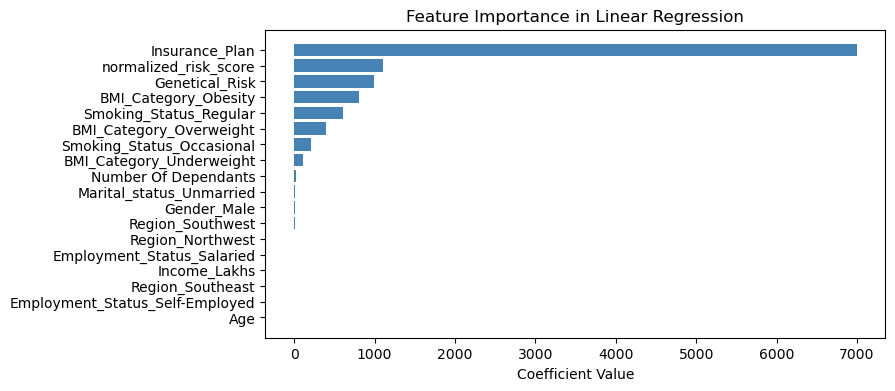

In [27]:
#Measuring the importance of each of the factors using a horizontal bar chart
feature_importance = lr_model.coef_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

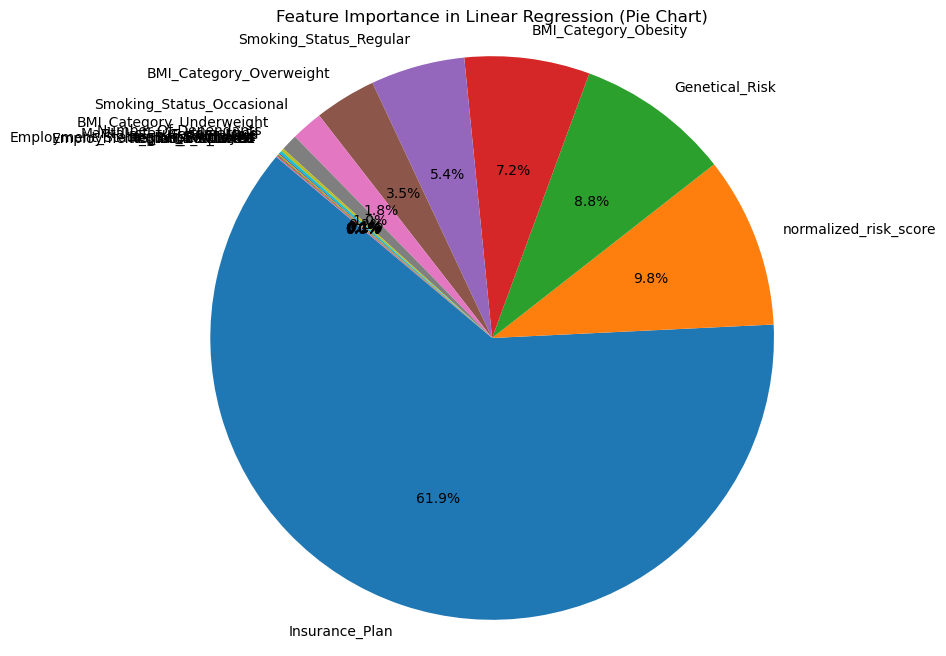

In [28]:
#Measuring the importance of each of the factors using a pie chart

import matplotlib.pyplot as plt

# Absolute coefficients as importance
feature_importance = abs(lr_model.coef_)

# Create DataFrame for plotting
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    coef_df['Importance'],
    labels=coef_df['Feature'],
    autopct='%1.1f%%',
    startangle=140
)
plt.title('Feature Importance in Linear Regression (Pie Chart)')
plt.axis('equal')  # Equal aspect ratio ensures a perfect circle
plt.show()


## Using Lasso and Ridge regression for different alpha values

In [29]:
alpha_values = [0.01, 0.1, 1]

# Define models and their parameter grids
model_params = {
    'Ridge': {
        'model': Ridge(),
        'params': {'alpha': alpha_values}
    },
    'Lasso': {
        'model': Lasso(max_iter=10000),
        'params': {'alpha': alpha_values}
    }
}

# Collect results
results = []

# Use R2 as scoring metric
scorer = make_scorer(r2_score)

# Loop through each model and perform GridSearchCV
for name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], scoring=scorer, cv=5, return_train_score=False)
    clf.fit(X_train, y_train)

    for i in range(len(clf.cv_results_['params'])):
        alpha = clf.cv_results_['params'][i]['alpha']
        mean_r2 = clf.cv_results_['mean_test_score'][i]
        results.append((name, alpha, mean_r2))

# Convert to DataFrame with MultiIndex
df_results = pd.DataFrame(results, columns=["Regression", "Alpha", "R2 Score"])
df_results.set_index(["Regression", "Alpha"], inplace=True)

# Display the result
df_results

R2 Score
Regression Alpha          
Ridge      0.01   0.988261
           0.10   0.988261
           1.00   0.988261
Lasso      0.01   0.988261
           0.10   0.988262
           1.00   0.988255

## Using Decision Tree

In [30]:
# Define the depths you want to try
depths = [5, 10, 15, 20]
results = []

# Loop through each depth and evaluate R2 with cross-validation
for depth in depths:
    model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    mean_r2 = scores.mean()
    results.append((depth, mean_r2))

# Create and format DataFrame
df_tree = pd.DataFrame(results, columns=["Max Depth", "R2 Score"])
df_tree.set_index("Max Depth", inplace=True)

# Display
df_tree


,R2 Score
Max Depth,
5,0.972651
10,0.985704
15,0.980973
20,0.977242


## Using XGBoost Regressor

In [31]:
# Parameter grid
model_xgb = XGBRegressor(n_estimators=20, max_depth=3)
model_xgb.fit(X_train, y_train)
model_xgb.score(X_test, y_test)


0.9876989126205444

In [32]:
model_xgb = XGBRegressor(tree_method='hist', verbosity=0)

# Smaller parameter grid
param_grid = {
    'n_estimators': [20, 50],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}

# Random search with fewer combinations
random_search = RandomizedSearchCV(
    model_xgb,
    param_grid,
    n_iter=10,
    cv=3,
    scoring='r2',
    random_state=42,
    n_jobs=1
)

# Fit the model
random_search.fit(X_train, y_train)

# Print best score and parameters
print("Best R2 Score:", random_search.best_score_)
print("Best Params:", random_search.best_params_)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best R2 Score: 0.9879226088523865
Best Params: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}


In [33]:
best_model = random_search.best_estimator_

## Error analysis

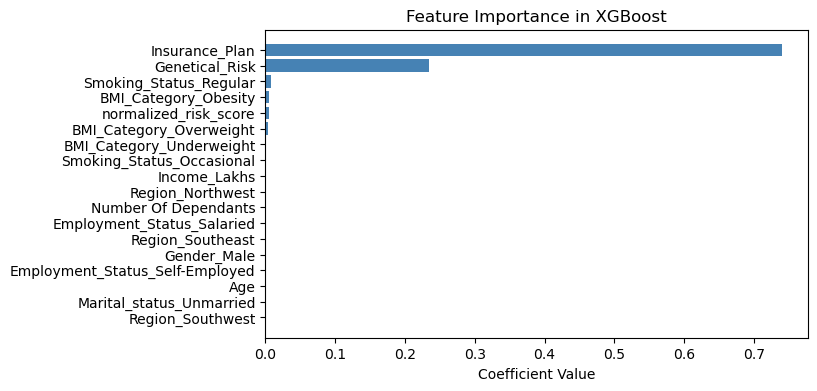

In [34]:
feature_importance = best_model.feature_importances_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients')

# Plotting
plt.figure(figsize=(7, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

In [35]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = (residuals / y_test) * 100

results_df = pd.DataFrame({
    'Actual Value': y_test, 
    'Predicted Value': y_pred, 
    'Difference in Values': residuals, 
    'Percentage Difference in Values': residuals_pct
})
results_df.head()

,Actual Value,Predicted Value,Difference in Values,Percentage Difference in Values
12774,6238,6104.117676,-133.882324,-2.146238
14758,9462,9593.652344,131.652344,1.391380
13205,5152,5619.506348,467.506348,9.074269
14278,6988,7377.886230,389.886230,5.579368
19351,4917,5109.857422,192.857422,3.922258


In [36]:
extreme_error_threshold = 10  
extreme_results_df = results_df[np.abs(results_df['Percentage Difference in Values']) > extreme_error_threshold]
extreme_results_df.head()

,Actual Value,Predicted Value,Difference in Values,Percentage Difference in Values
12669,3985,4487.946777,502.946777,12.620998
2918,4517,5070.301270,553.301270,12.249309
17084,3562,4097.839844,535.839844,15.043230
7181,3630,4097.839844,467.839844,12.888150
12285,3532,4097.839844,565.839844,16.020381


In [37]:
extreme_errors_pct = extreme_results_df.shape[0]*100/X_test.shape[0]
extreme_errors_pct

2.489213408562894

In [38]:
extreme_results_df[abs(extreme_results_df['Percentage Difference in Values'])>50].sort_values("Percentage Difference in Values",ascending=False)

,Actual Value,Predicted Value,Difference in Values,Percentage Difference in Values


In [39]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head(2)

,Age,Number Of Dependants,Income_Lakhs,Insurance_Plan,Genetical_Risk,normalized_risk_score,Gender_Male,Region_Northwest,Region_Southeast,Region_Southwest,Marital_status_Unmarried,BMI_Category_Obesity,BMI_Category_Overweight,BMI_Category_Underweight,Smoking_Status_Occasional,Smoking_Status_Regular,Employment_Status_Salaried,Employment_Status_Self-Employed
12669,0.857143,0.0,0.000000,0.0,0,0.0,1,0,1,0,1,0,1,0,0,0,1,0
2918,0.285714,0.0,0.151515,0.0,1,0.0,1,1,0,0,1,0,0,0,0,0,1,0


## Exporting the model

In [46]:
from joblib import dump

dump(best_model, "artifacts/model_young.joblib")
scaler_with_cols = {
    'scaler': scaler,
    'cols_to_scale': cols_to_scale
}
dump(scaler_with_cols, "artifacts/scaler_young.joblib")

['artifacts/scaler_young.joblib']